In [82]:
# Nurture Me — End-to-end model in one notebook

import re
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

# Pretty printing options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [83]:
# Point to your CSV (keep it next to this notebook)
DATA_PATH = "mental_disorder.csv"

df = pd.read_csv(DATA_PATH)
df.columns = [c.strip() for c in df.columns]  # normalize col names

print("Shape:", df.shape)
display(df.head(10))
print(df.columns.tolist())


Shape: (120, 19)


,Patient Number,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,Patiant-01,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,Patiant-02,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression
2,Patiant-03,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6 From 10,5 From 10,7 From 10,Bipolar Type-1
3,Patiant-04,Usually,Seldom,Usually,Most-Often,YES,YES,YES,NO,YES,NO,NO,NO,NO,NO,3 From 10,2 From 10,2 From 10,Bipolar Type-2
4,Patiant-05,Usually,Usually,Sometimes,Sometimes,NO,NO,NO,NO,NO,NO,NO,YES,YES,YES,5 From 10,5 From 10,6 From 10,Normal
5,Patiant-06,Usually,Sometimes,Sometimes,Most-Often,NO,YES,YES,YES,NO,NO,NO,NO,YES,NO,3 From 10,5 From 10,5 From 10,Depression
6,Patiant-07,Seldom,Usually,Seldom,Sometimes,YES,YES,YES,NO,YES,YES,NO,YES,YES,YES,7 From 10,2 From 10,9 From 10,Bipolar Type-1
7,Patiant-08,Usually,Sometimes,Sometimes,Sometimes,NO,NO,NO,NO,YES,NO,NO,NO,NO,YES,5 From 10,5 From 10,5 From 10,Normal
8,Patiant-09,Most-Often,Seldom,Most-Often,Usually,YES,YES,YES,NO,YES,YES,NO,YES,NO,NO,8 From 10,2 From 10,3 From 10,Bipolar Type-2
9,Patiant-10,Usually,Seldom,Most-Often,Sometimes,NO,NO,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,4 From 10,2 From 10,Depression


['Patient Number', 'Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder', 'Mood Swing', 'Suicidal thoughts', 'Anorxia', 'Authority Respect', 'Try-Explanation', 'Aggressive Response', 'Ignore & Move-On', 'Nervous Break-down', 'Admit Mistakes', 'Overthinking', 'Sexual Activity', 'Concentration', 'Optimisim', 'Expert Diagnose']


In [90]:
# Expected schema (from your dataset)
ID_COL = "Patient Number"
TARGET_COL = "Expert Diagnose"

ORDINAL4_COLS = ["Sadness", "Euphoric", "Exhausted", "Sleep dissorder"]
BINARY_COLS = [
    "Mood Swing","Suicidal thoughts","Anorxia","Authority Respect","Try-Explanation",
    "Aggressive Response","Ignore & Move-On","Nervous Break-down","Admit Mistakes","Overthinking"
]
SCALE10_COLS = ["Sexual Activity", "Concentration", "Optimisim"]

# 1) strip whitespace from *each string element*
dfc = df.copy()
for c in dfc.columns:
    if dfc[c].dtype == object:
        dfc[c] = dfc[c].astype(str).str.strip()

# 2) ordinal mapping
ORDINAL_MAP = {"Seldom": 0, "Sometimes": 1, "Usually": 2, "Most-Often": 3}
for c in ORDINAL4_COLS:
    dfc[c] = dfc[c].map(ORDINAL_MAP)
    if dfc[c].isna().any():
        bad = sorted(df[c].astype(str).unique())
        raise ValueError(f"Unexpected values in '{c}'. Saw {bad}. Expected {list(ORDINAL_MAP.keys())}.")

# 3) binary mapping YES/NO
def map_yes_no(x: str) -> int:
    s = str(x).strip().upper()
    if s == "YES": return 1
    if s == "NO":  return 0
    raise ValueError(f"Unexpected YES/NO value: {x}")

for c in BINARY_COLS:
    dfc[c] = dfc[c].apply(map_yes_no)

# 4) parse "N From 10" -> N
def parse_from_10(x: str) -> int:
    m = re.search(r"(\d+)", str(x))
    if m: return int(m.group(1))
    raise ValueError(f"Unexpected 'From 10' value: {x}")

for c in SCALE10_COLS:
    dfc[c] = dfc[c].apply(parse_from_10)

# 5) target encode
y_raw = dfc[TARGET_COL].astype(str).str.strip()
CLASSES = sorted(y_raw.unique())
LABEL_TO_ID = {lab: i for i, lab in enumerate(CLASSES)}
ID_TO_LABEL = {i: lab for lab, i in LABEL_TO_ID.items()}
y = y_raw.map(LABEL_TO_ID)

# 6) features
X = dfc.drop(columns=[ID_COL, TARGET_COL])

print("Final feature matrix shape:", X.shape)
display(X.head())
print("Classes:", CLASSES)


Final feature matrix shape: (120, 17)


,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim
0,2,0,1,1,1,1,0,0,1,0,0,1,1,1,3,3,4
1,2,0,2,1,0,1,0,0,0,0,0,0,0,0,4,2,5
2,1,3,1,1,1,0,0,0,1,1,0,1,1,0,6,5,7
3,2,0,2,3,1,1,1,0,1,0,0,0,0,0,3,2,2
4,2,2,1,1,0,0,0,0,0,0,0,1,1,1,5,5,6


Classes: ['Bipolar Type-1', 'Bipolar Type-2', 'Depression', 'Normal']


In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (96, 17)  Test size: (24, 17)


In [92]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = Pipeline([("clf", RandomForestClassifier(random_state=42))])

param_grid = [
    {
        "clf": [RandomForestClassifier(random_state=42)],
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_leaf": [1, 2],
        "clf__class_weight": [None, "balanced_subsample"],
    },
    {
        "clf": [LogisticRegression(max_iter=2000, multi_class="auto")],
        "clf__C": [0.1, 1.0, 10.0],
        "clf__class_weight": [None, "balanced"],
        "clf__solver": ["liblinear", "lbfgs"],
    },
]

gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    refit=True,
    verbose=1
)

gscv.fit(X_train, y_train)

best_model = gscv.best_estimator_
best_params = gscv.best_params_
cv_best_f1 = gscv.best_score_

print("\nBest CV F1 (macro):", round(cv_best_f1, 4))
print("Best Params:", {k: (type(v).__name__ if k == "clf" else v) for k, v in best_params.items()})


Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best CV F1 (macro): 0.8827
Best Params: {'clf': 'RandomForestClassifier', 'clf__class_weight': 'balanced_subsample', 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 500}


Test Accuracy: 0.9167
Test F1 (macro): 0.9115

Classification Report:
                 precision    recall  f1-score   support

Bipolar Type-1       1.00      1.00      1.00         6
Bipolar Type-2       0.86      1.00      0.92         6
    Depression       0.86      1.00      0.92         6
        Normal       1.00      0.67      0.80         6

      accuracy                           0.92        24
     macro avg       0.93      0.92      0.91        24
  weighted avg       0.93      0.92      0.91        24



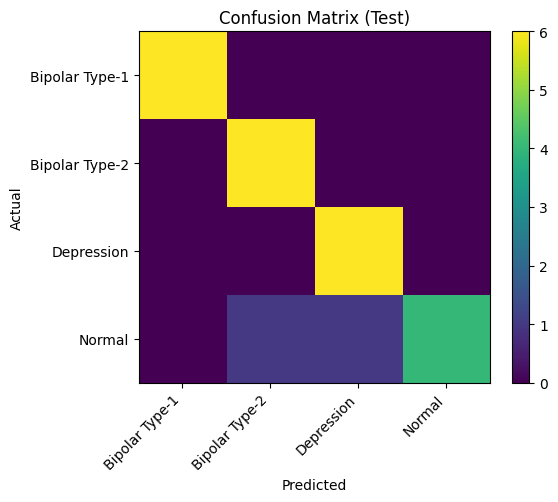

In [93]:
y_pred = best_model.predict(X_test)

acc = (y_pred == y_test).mean()
macro_f1 = f1_score(y_test, y_pred, average="macro")
report = classification_report(
    y_test, y_pred,
    target_names=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())]
)

print("Test Accuracy:", round(acc, 4))
print("Test F1 (macro):", round(macro_f1, 4))
print("\nClassification Report:\n", report)

# Confusion Matrix (matplotlib; no custom colors)
cm = confusion_matrix(y_test, y_pred, labels=sorted(ID_TO_LABEL.keys()))

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.xticks(
    ticks=range(len(ID_TO_LABEL)),
    labels=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())],
    rotation=45, ha="right"
)
plt.yticks(
    ticks=range(len(ID_TO_LABEL)),
    labels=[ID_TO_LABEL[i] for i in sorted(ID_TO_LABEL.keys())]
)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [94]:
# If RandomForest selected, show Gini importances; else fall back to permutation importances
if hasattr(best_model.named_steps["clf"], "feature_importances_"):
    fi = best_model.named_steps["clf"].feature_importances_
    feature_importances = pd.Series(fi, index=X.columns).sort_values(ascending=False)
else:
    r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    feature_importances = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)

display(feature_importances.head(10).to_frame("importance"))


,importance
Mood Swing,0.277243
Optimisim,0.123601
Sexual Activity,0.101301
Sadness,0.090619
Suicidal thoughts,0.066963
Euphoric,0.056160
Concentration,0.043828
Exhausted,0.039317
Aggressive Response,0.036744
Authority Respect,0.033851


In [95]:
# Provide a pure-notebook inference function using the same schema & maps

def _map_yes_no(x: str) -> int:
    s = str(x).strip().upper()
    if s == "YES": return 1
    if s == "NO":  return 0
    raise ValueError(f"Unexpected YES/NO value: {x}")

def _parse_from_10(x: str) -> int:
    m = re.search(r"(\d+)", str(x))
    if m: return int(m.group(1))
    raise ValueError(f"Unexpected 'From 10' value: {x}")

def _map_ordinal4(x: str) -> int:
    xx = str(x).strip()
    if xx not in ORDINAL_MAP:
        raise ValueError(f"Unexpected ordinal value: {x}. Expected {list(ORDINAL_MAP.keys())}")
    return ORDINAL_MAP[xx]

def transform_raw_to_features(raw: dict) -> pd.DataFrame:
    expected = set(ORDINAL4_COLS + BINARY_COLS + SCALE10_COLS)
    if set(raw.keys()) != expected:
        missing = expected - set(raw.keys())
        extra = set(raw.keys()) - expected
        raise ValueError(f"Keys mismatch. Missing: {missing}, Extra: {extra}")

    row = {}
    for c in ORDINAL4_COLS: row[c] = _map_ordinal4(raw[c])
    for c in BINARY_COLS:  row[c] = _map_yes_no(raw[c])
    for c in SCALE10_COLS: row[c] = _parse_from_10(raw[c])
    return pd.DataFrame([row])

def predict_from_raw(raw: dict):
    Xone = transform_raw_to_features(raw)
    pred_id = int(best_model.predict(Xone)[0])
    proba = None
    # predict_proba if available
    clf = best_model.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        p = clf.predict_proba(Xone)[0]
        proba = {ID_TO_LABEL[i]: float(p[i]) for i in range(len(p))}
    return {"prediction": ID_TO_LABEL[pred_id], "proba": proba}

# Demo
demo_input = {
    "Sadness": "Usually",
    "Euphoric": "Seldom",
    "Exhausted": "Sometimes",
    "Sleep dissorder": "Most-Often",
    "Mood Swing": "YES",
    "Suicidal thoughts": "NO",
    "Anorxia": "NO",
    "Authority Respect": "YES",
    "Try-Explanation": "YES",
    "Aggressive Response": "NO",
    "Ignore & Move-On": "YES",
    "Nervous Break-down": "NO",
    "Admit Mistakes": "YES",
    "Overthinking": "NO",
    "Sexual Activity": "5 From 10",
    "Concentration": "6 From 10",
    "Optimisim": "7 From 10"
}
predict_from_raw(demo_input)


{'prediction': 'Bipolar Type-1',
 'proba': {'Bipolar Type-1': 0.3559915280724687,
  'Bipolar Type-2': 0.354289208027089,
  'Depression': 0.053984895495311,
  'Normal': 0.2357343684051313}}

In [96]:
# If you want, you can keep all critical objects in a single dict for later cells:
SESSION_ARTIFACTS = {
    "best_model": best_model,
    "id_to_label": ID_TO_LABEL,
    "label_to_id": LABEL_TO_ID,
    "ordinal_map": ORDINAL_MAP,
    "schema": {
        "ID_COL": ID_COL, "TARGET_COL": TARGET_COL,
        "ORDINAL4_COLS": ORDINAL4_COLS, "BINARY_COLS": BINARY_COLS, "SCALE10_COLS": SCALE10_COLS
    }
}
print("Artifacts captured in-memory.")


Artifacts captured in-memory.


All libraries imported successfully!
Starting Mental Health AI Assistant notebook...
Dataset Shape: (120, 19)

First few rows:
  Patient Number    Sadness    Euphoric  Exhausted Sleep dissorder Mood Swing Suicidal thoughts Anorxia  \
0     Patiant-01    Usually      Seldom  Sometimes       Sometimes        YES              YES       NO   
1     Patiant-02    Usually      Seldom    Usually       Sometimes         NO               YES      NO   
2     Patiant-03  Sometimes  Most-Often  Sometimes       Sometimes        YES                NO      NO   
3     Patiant-04    Usually      Seldom    Usually      Most-Often        YES               YES     YES   
4     Patiant-05    Usually     Usually  Sometimes       Sometimes         NO                NO      NO   

  Authority Respect Try-Explanation Aggressive Response Ignore & Move-On Nervous Break-down Admit Mistakes  \
0                NO             YES                  NO               NO                YES            YES   
1         

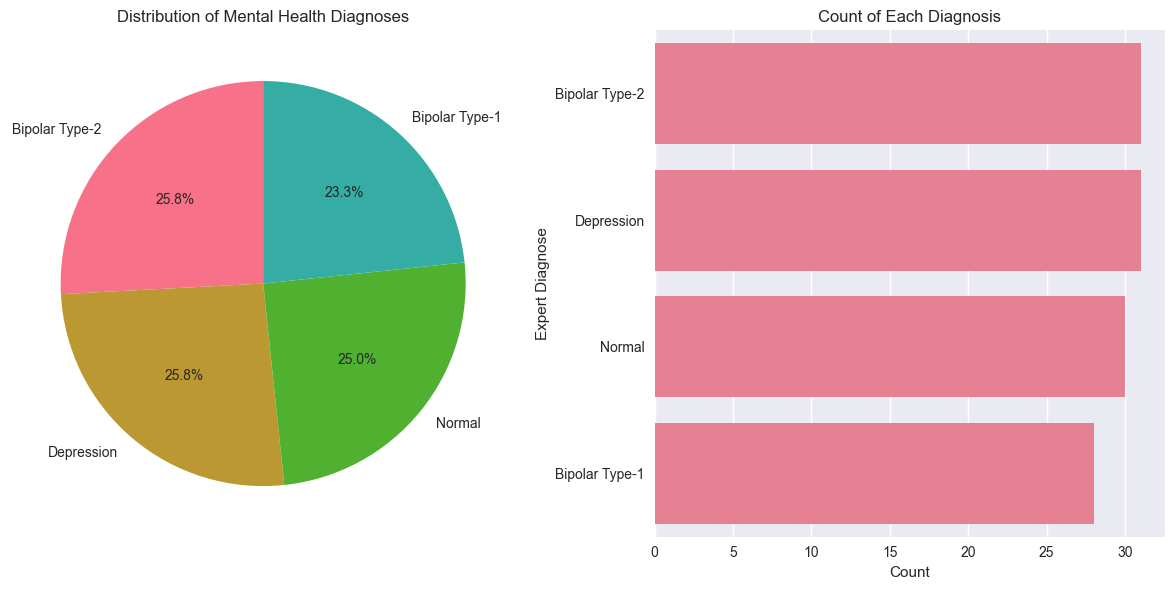

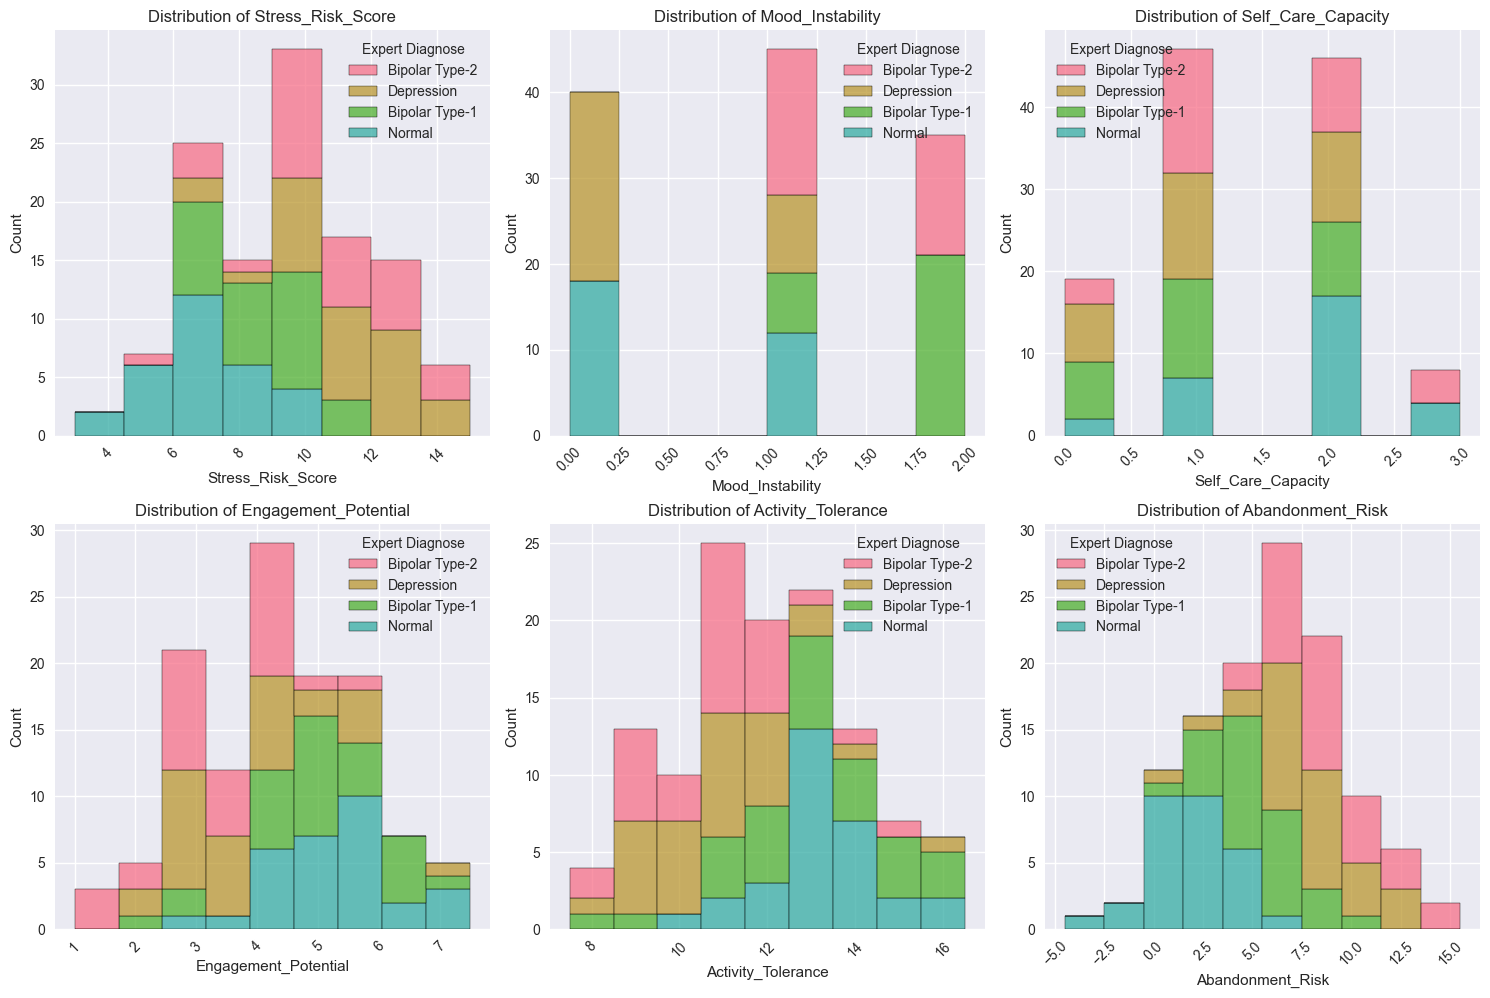

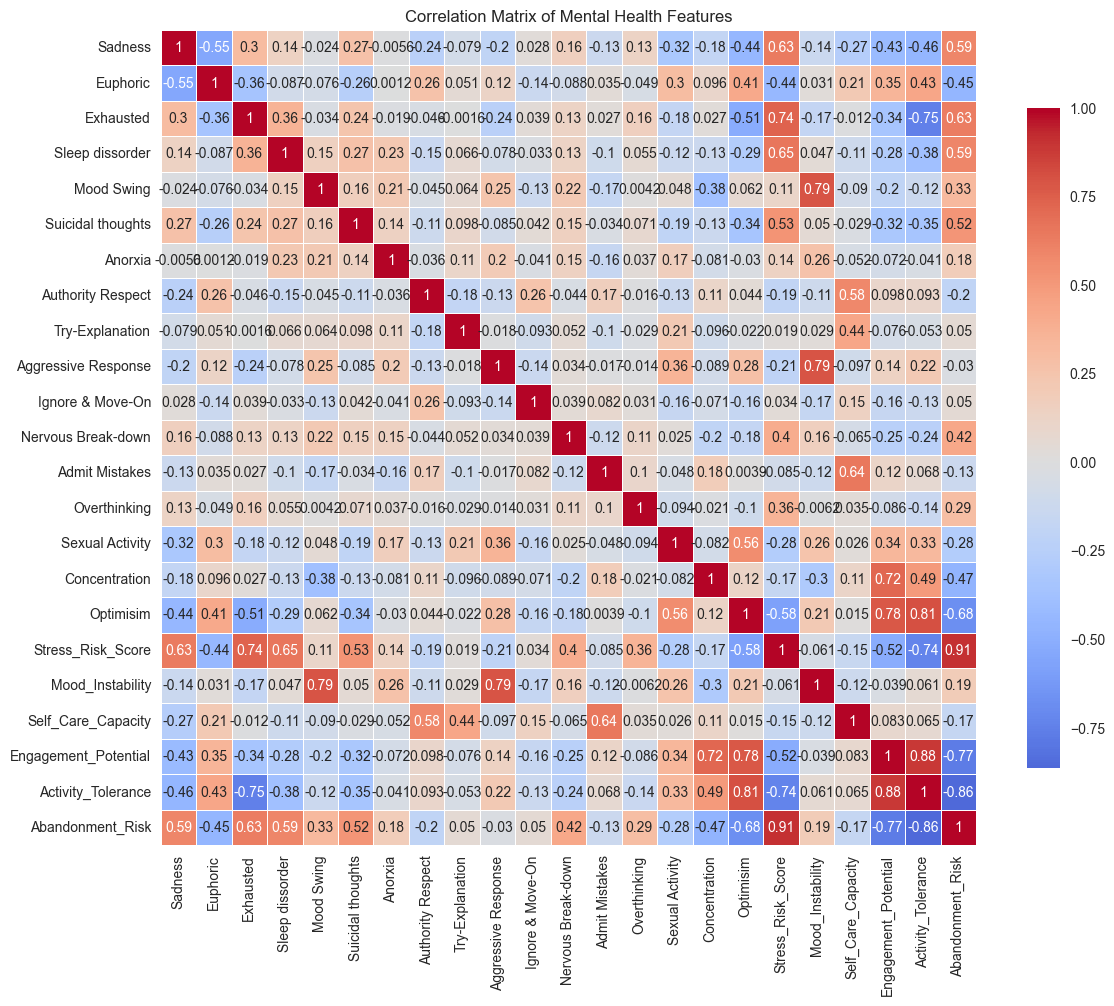

Preparing features for clustering...
Feature columns: ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder', 'Mood Swing', 'Suicidal thoughts', 'Stress_Risk_Score', 'Engagement_Potential', 'Activity_Tolerance']
Features shape: (120, 9)
NaN values per column:
Sadness                 0
Euphoric                0
Exhausted               0
Sleep dissorder         0
Mood Swing              0
Suicidal thoughts       0
Stress_Risk_Score       0
Engagement_Potential    0
Activity_Tolerance      0
dtype: int64
Final features - Shape: (120, 9)
Final NaN check: 0
Final inf check: 0
Features standardized. Performing K-means clustering...
Clustering completed successfully!
User Profile Analysis:
              Stress_Risk_Score  Engagement_Potential  Activity_Tolerance  Abandonment_Risk Expert Diagnose
User_Profile                                                                                               
0                          9.55                  3.84               10.43              6.52 

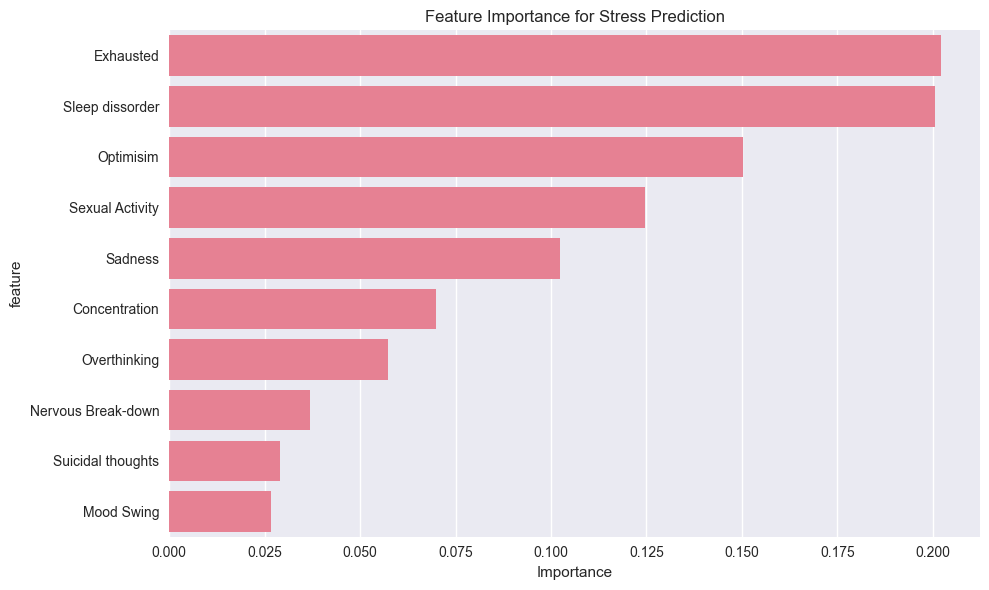


Abandonment Prediction Model Accuracy: 0.722

Classification Report:
              precision    recall  f1-score   support

        High       0.64      0.70      0.67        10
         Low       0.80      0.89      0.84         9
    Moderate       0.75      0.55      0.63        11
   Very High       0.71      0.83      0.77         6

    accuracy                           0.72        36
   macro avg       0.73      0.74      0.73        36
weighted avg       0.72      0.72      0.72        36


COMPONENT STATUS CHECK
✓ Data processed: 120 patients
✓ User profiles created: 5 clusters
✓ Stress prediction model: Trained
✓ Abandonment prediction model: Trained
✓ All components ready for AI Assistant initialization
Initializing AI Assistant with all trained models...
✓ AI Assistant initialized successfully!

MENTAL HEALTH AI ASSISTANT - EXAMPLE ANALYSIS

User Profile Cluster: 4
Predicted Stress Level: Severe
Abandonment Risk: High

Habit Recommendations:
  Meditation: short mindfulnes

In [170]:
# Mental Health AI Assistant - Complete Analysis & Model Training
# This notebook implements habit suggestion, stress prediction, dynamic adjustments, and abandonment detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print("Starting Mental Health AI Assistant notebook...")

# Load and explore the data
df = pd.read_csv('mental_disorder.csv')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nExpert Diagnose distribution:")
print(df['Expert Diagnose'].value_counts())

# Data preprocessing
def preprocess_data(df):
    """Preprocess the mental health data"""
    df_processed = df.copy()
    
    # Handle the typo in patient numbering
    df_processed['Patient Number'] = df_processed['Patient Number'].str.replace('Patiant', 'Patient')
    
    # Remove leading/trailing whitespace from all string columns
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object':
            df_processed[col] = df_processed[col].astype(str).str.strip()
    
    print("Checking for data issues...")
    
    # Frequency columns (Usually, Sometimes, etc.)
    frequency_cols = ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder']
    frequency_mapping = {'Seldom': 1, 'Sometimes': 2, 'Usually': 3, 'Most-Often': 4}
    
    for col in frequency_cols:
        print(f"Unique values in {col}: {df_processed[col].unique()}")
        
        # Check if already numeric (1-4)
        if df_processed[col].dtype in ['int64', 'float64']:
            unique_vals = set(df_processed[col].dropna().unique())
            if unique_vals.issubset({1, 2, 3, 4, 1.0, 2.0, 3.0, 4.0}):
                print(f"  {col} already processed as frequency (1-4)")
                continue
        
        # Handle potential issues with mapping for string columns
        if df_processed[col].dtype == 'object':
            df_processed[col] = df_processed[col].map(frequency_mapping)
        
        # Fill any NaN values with median (2 = Sometimes)
        if df_processed[col].isnull().any():
            df_processed[col].fillna(2, inplace=True)
            print(f"Warning: Found and filled NaN values in {col}")
        
        # Ensure it's numeric
        df_processed[col] = df_processed[col].astype(int)
    
    # Binary columns (YES/NO)
    binary_cols = ['Mood Swing', 'Suicidal thoughts', 'Anorxia', 'Authority Respect', 
                   'Try-Explanation', 'Aggressive Response', 'Ignore & Move-On', 
                   'Nervous Break-down', 'Admit Mistakes', 'Overthinking']
    
    for col in binary_cols:
        print(f"Unique values in {col}: {df_processed[col].unique()}")
        
        # Check if already numeric (0/1)
        if df_processed[col].dtype in ['int64', 'float64']:
            unique_vals = set(df_processed[col].dropna().unique())
            if unique_vals.issubset({0, 1, 0.0, 1.0}):
                print(f"  {col} already processed as binary (0/1)")
                continue
        
        # Handle variations in YES/NO values for string columns
        if df_processed[col].dtype == 'object':
            df_processed[col] = df_processed[col].astype(str).str.upper().str.strip()
            df_processed[col] = df_processed[col].map({'NO': 0, 'YES': 1})
        
        # Fill any NaN values with 0 (NO)
        if df_processed[col].isnull().any():
            df_processed[col].fillna(0, inplace=True)
            print(f"Warning: Found and filled NaN values in {col}")
        
        # Ensure it's numeric
        df_processed[col] = df_processed[col].astype(int)
    
    # Extract numeric values from rating columns
    rating_cols = ['Sexual Activity', 'Concentration', 'Optimisim']
    for col in rating_cols:
        print(f"Sample values in {col}: {df_processed[col].head().tolist()}")
        
        # Check if already numeric
        if df_processed[col].dtype in ['int64', 'float64']:
            print(f"  {col} already processed as numeric")
            # Just fill NaN values if any
            if df_processed[col].isnull().any():
                median_val = df_processed[col].median()
                if pd.isna(median_val):
                    median_val = 5  # Default middle value
                df_processed[col].fillna(median_val, inplace=True)
                print(f"Warning: Found and filled NaN values in {col}")
        else:
            # Extract numbers more robustly for string columns
            df_processed[col] = df_processed[col].astype(str).str.extract('(\d+)').astype(float)
            # Fill any NaN values with median rating (5)
            if df_processed[col].isnull().any():
                median_val = df_processed[col].median()
                if pd.isna(median_val):
                    median_val = 5  # Default middle value
                df_processed[col].fillna(median_val, inplace=True)
                print(f"Warning: Found and filled NaN values in {col}")
        
        # Ensure it's numeric integer
        df_processed[col] = df_processed[col].astype(int)
    
    # Final check for any remaining NaN values
    nan_cols = df_processed.columns[df_processed.isnull().any()].tolist()
    if nan_cols:
        print(f"Warning: Still have NaN values in columns: {nan_cols}")
        # Fill remaining NaN values with appropriate defaults
        for col in nan_cols:
            if df_processed[col].dtype in ['int64', 'float64']:
                df_processed[col].fillna(df_processed[col].median(), inplace=True)
            else:
                df_processed[col].fillna('Unknown', inplace=True)
    
    # Encode target variable
    le_target = LabelEncoder()
    df_processed['Target'] = le_target.fit_transform(df_processed['Expert Diagnose'])
    
    print("Data preprocessing completed successfully!")
    print(f"Final shape: {df_processed.shape}")
    print(f"Remaining NaN values: {df_processed.isnull().sum().sum()}")
    
    return df_processed, le_target

# Preprocess the data
df_processed, target_encoder = preprocess_data(df)
print("\nProcessed data shape:", df_processed.shape)
print("\nTarget encoding:")
for i, label in enumerate(target_encoder.classes_):
    print(f"{i}: {label}")

# Feature engineering for AI assistant capabilities
def create_ai_features(df):
    """Create additional features for AI assistant capabilities"""
    df_enhanced = df.copy()
    
    # Stress/Burnout Risk Score
    stress_indicators = ['Sadness', 'Exhausted', 'Sleep dissorder', 'Suicidal thoughts', 
                        'Nervous Break-down', 'Overthinking']
    df_enhanced['Stress_Risk_Score'] = df_enhanced[stress_indicators].sum(axis=1)
    
    # Mood Stability Score (lower is more stable)
    df_enhanced['Mood_Instability'] = df_enhanced['Mood Swing'] + df_enhanced['Aggressive Response']
    
    # Self-Care Capacity Score
    self_care_indicators = ['Authority Respect', 'Try-Explanation', 'Admit Mistakes']
    df_enhanced['Self_Care_Capacity'] = df_enhanced[self_care_indicators].sum(axis=1)
    
    # Engagement Potential Score
    df_enhanced['Engagement_Potential'] = (df_enhanced['Concentration'] + df_enhanced['Optimisim']) / 2
    
    # Activity Tolerance Score (based on energy and mood)
    df_enhanced['Activity_Tolerance'] = (10 - df_enhanced['Exhausted']) + df_enhanced['Engagement_Potential']
    
    # Risk of Abandonment Score (high stress, low engagement, mood swings)
    df_enhanced['Abandonment_Risk'] = (df_enhanced['Stress_Risk_Score'] + 
                                      df_enhanced['Mood_Instability'] - 
                                      df_enhanced['Engagement_Potential'])
    
    return df_enhanced

# Create enhanced features
df_enhanced = create_ai_features(df_processed)
print("\nEnhanced features created:")
print(['Stress_Risk_Score', 'Mood_Instability', 'Self_Care_Capacity', 
       'Engagement_Potential', 'Activity_Tolerance', 'Abandonment_Risk'])

# Exploratory Data Analysis
def plot_diagnosis_distribution():
    """Plot the distribution of mental health diagnoses"""
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    diagnosis_counts = df['Expert Diagnose'].value_counts()
    plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Mental Health Diagnoses')
    
    plt.subplot(1, 2, 2)
    sns.countplot(data=df, y='Expert Diagnose', order=diagnosis_counts.index)
    plt.title('Count of Each Diagnosis')
    plt.xlabel('Count')
    
    plt.tight_layout()
    plt.show()

def plot_ai_features():
    """Plot the AI-specific features"""
    plt.figure(figsize=(15, 10))
    
    ai_features = ['Stress_Risk_Score', 'Mood_Instability', 'Self_Care_Capacity', 
                   'Engagement_Potential', 'Activity_Tolerance', 'Abandonment_Risk']
    
    for i, feature in enumerate(ai_features, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=df_enhanced, x=feature, hue='Expert Diagnose', multiple="stack")
        plt.title(f'Distribution of {feature}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix():
    """Plot correlation matrix of key features"""
    plt.figure(figsize=(12, 10))
    
    # Select numeric columns for correlation
    numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns
    numeric_cols = numeric_cols.drop(['Target'])  # Remove target from correlation
    
    correlation_matrix = df_enhanced[numeric_cols].corr()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Mental Health Features')
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_diagnosis_distribution()
plot_ai_features()
plot_correlation_matrix()

# User profiling for collaborative filtering
def create_user_profiles(df):
    """Create user profiles for collaborative filtering"""
    # Use clustering to identify similar user profiles
    feature_cols = ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder', 'Mood Swing',
                   'Suicidal thoughts', 'Stress_Risk_Score', 'Engagement_Potential', 
                   'Activity_Tolerance']
    
    print("Preparing features for clustering...")
    print(f"Feature columns: {feature_cols}")
    
    # Check if all feature columns exist
    missing_cols = [col for col in feature_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols}. Skipping them.")
        feature_cols = [col for col in feature_cols if col in df.columns]
    
    # Extract features and check for NaN values
    features = df[feature_cols].copy()
    print(f"Features shape: {features.shape}")
    print(f"NaN values per column:\n{features.isnull().sum()}")
    
    # Fill any remaining NaN values
    if features.isnull().any().any():
        print("Filling remaining NaN values with column medians...")
        features = features.fillna(features.median())
    
    # Verify no infinite values
    if np.isinf(features.values).any():
        print("Warning: Found infinite values. Replacing with column medians...")
        features = features.replace([np.inf, -np.inf], np.nan)
        features = features.fillna(features.median())
    
    # Final validation
    print(f"Final features - Shape: {features.shape}")
    print(f"Final NaN check: {features.isnull().sum().sum()}")
    print(f"Final inf check: {np.isinf(features.values).sum()}")
    
    # Standardize features for clustering
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    print("Features standardized. Performing K-means clustering...")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df['User_Profile'] = kmeans.fit_predict(features_scaled)
    
    print("Clustering completed successfully!")
    
    # Analyze profiles
    profile_analysis = df.groupby('User_Profile').agg({
        'Stress_Risk_Score': 'mean',
        'Engagement_Potential': 'mean',
        'Activity_Tolerance': 'mean',
        'Abandonment_Risk': 'mean',
        'Expert Diagnose': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'  # Most common diagnosis in cluster
    }).round(2)
    
    print("User Profile Analysis:")
    print(profile_analysis)
    
    return df, scaler, kmeans, profile_analysis

df_enhanced, profile_scaler, profile_model, profile_analysis = create_user_profiles(df_enhanced)

# Habit Recommendation System
class HabitRecommendationSystem:
    def __init__(self, profile_analysis):
        self.profile_analysis = profile_analysis
        
        # Define habit recommendations for each profile
        self.habit_recommendations = {
            0: {
                'meditation': ['5-min breathing exercises', 'body scan meditation'],
                'exercise': ['gentle yoga', 'short walks', 'stretching'],
                'focus': ['single-tasking practice', 'mindful eating'],
                'motivation': 'Start small and be gentle with yourself'
            },
            1: {
                'meditation': ['guided meditation apps', 'progressive muscle relaxation'],
                'exercise': ['moderate cardio', 'swimming', 'dancing'],
                'focus': ['pomodoro technique', 'journaling'],
                'motivation': 'Consistency over intensity'
            },
            2: {
                'meditation': ['loving-kindness meditation', 'gratitude practice'],
                'exercise': ['team sports', 'hiking', 'cycling'],
                'focus': ['creative activities', 'learning new skills'],
                'motivation': 'Channel your energy positively'
            },
            3: {
                'meditation': ['mindfulness meditation', 'meditation retreats'],
                'exercise': ['strength training', 'martial arts', 'running'],
                'focus': ['deep work sessions', 'goal setting'],
                'motivation': 'Push your boundaries mindfully'
            },
            4: {
                'meditation': ['short mindfulness breaks', 'walking meditation'],
                'exercise': ['low-impact activities', 'tai chi', 'water exercises'],
                'focus': ['one thing at a time', 'stress reduction techniques'],
                'motivation': 'Recovery and self-compassion first'
            }
        }
    
    def recommend_habits(self, user_profile, stress_score, engagement_score):
        """Recommend habits based on user profile and current state"""
        base_recommendations = self.habit_recommendations.get(user_profile, self.habit_recommendations[0])
        
        # Adjust recommendations based on current stress and engagement
        if stress_score > 8:
            # High stress - focus on calming activities
            recommendations = {
                'meditation': base_recommendations['meditation'][:1],  # Just one gentle option
                'exercise': ['gentle yoga', 'slow walking'],
                'focus': ['breathing exercises', 'mindful moments'],
                'motivation': 'Take it one breath at a time'
            }
        elif engagement_score < 3:
            # Low engagement - very simple activities
            recommendations = {
                'meditation': ['1-minute breathing'],
                'exercise': ['gentle stretching'],
                'focus': ['single mindful activity'],
                'motivation': 'Every small step counts'
            }
        else:
            recommendations = base_recommendations
        
        return recommendations

# Stress/Burnout Prediction Model
def train_stress_prediction_model(df):
    """Train a model to predict stress levels and burnout risk"""
    
    # Create stress level categories
    df['Stress_Level'] = pd.cut(df['Stress_Risk_Score'], 
                               bins=[0, 3, 6, 9, float('inf')], 
                               labels=['Low', 'Moderate', 'High', 'Severe'])
    
    # Prepare features for stress prediction
    stress_features = ['Sadness', 'Exhausted', 'Sleep dissorder', 'Mood Swing',
                      'Suicidal thoughts', 'Nervous Break-down', 'Overthinking',
                      'Concentration', 'Optimisim', 'Sexual Activity']
    
    X = df[stress_features]
    y = df['Stress_Level']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train Random Forest model
    rf_stress = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_stress.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = rf_stress.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nStress Prediction Model Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': stress_features,
        'importance': rf_stress.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance for Stress Prediction')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return rf_stress, feature_importance

# Train stress prediction model
stress_model, stress_features = train_stress_prediction_model(df_enhanced)

# Dynamic Activity Adjustment System
class DynamicActivityAdjuster:
    def __init__(self, stress_model):
        self.stress_model = stress_model
    
    def adjust_activity_intensity(self, user_data):
        """Dynamically adjust activity intensity based on predicted engagement and stress"""
        
        # Predict current stress level
        stress_features = ['Sadness', 'Exhausted', 'Sleep dissorder', 'Mood Swing',
                          'Suicidal thoughts', 'Nervous Break-down', 'Overthinking',
                          'Concentration', 'Optimisim', 'Sexual Activity']
        
        # Extract stress feature values properly
        stress_values = [user_data[feature] for feature in stress_features]
        stress_prediction = self.stress_model.predict([stress_values])[0]
        
        # Base activity recommendations
        activities = {
            'meditation': {'duration': 10, 'intensity': 'medium', 'type': 'guided'},
            'exercise': {'duration': 30, 'intensity': 'medium', 'type': 'cardio'},
            'focus': {'duration': 25, 'intensity': 'medium', 'type': 'work'}
        }
        
        # Adjust based on stress level
        if stress_prediction == 'Severe':
            for activity in activities:
                activities[activity]['duration'] //= 3
                activities[activity]['intensity'] = 'very_low'
                if activity == 'meditation':
                    activities[activity]['type'] = 'breathing'
                elif activity == 'exercise':
                    activities[activity]['type'] = 'gentle_stretching'
                else:
                    activities[activity]['type'] = 'mindful_break'
                    
        elif stress_prediction == 'High':
            for activity in activities:
                activities[activity]['duration'] = int(activities[activity]['duration'] * 0.6)
                activities[activity]['intensity'] = 'low'
                
        elif stress_prediction == 'Low':
            for activity in activities:
                activities[activity]['duration'] = int(activities[activity]['duration'] * 1.2)
                activities[activity]['intensity'] = 'high'
        
        return activities, stress_prediction

# Habit Abandonment Detection System
def train_abandonment_prediction_model(df):
    """Train a model to predict habit abandonment risk"""
    
    # Create abandonment risk categories
    df['Abandonment_Risk_Level'] = pd.cut(df['Abandonment_Risk'], 
                                         bins=[float('-inf'), 2, 5, 8, float('inf')], 
                                         labels=['Low', 'Moderate', 'High', 'Very High'])
    
    # Features for abandonment prediction
    abandonment_features = ['Stress_Risk_Score', 'Mood_Instability', 'Engagement_Potential',
                           'Self_Care_Capacity', 'Activity_Tolerance', 'Concentration',
                           'Optimisim', 'Overthinking']
    
    X = df[abandonment_features]
    y = df['Abandonment_Risk_Level']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train Gradient Boosting model
    gb_abandon = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_abandon.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = gb_abandon.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\nAbandonment Prediction Model Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return gb_abandon

# Train abandonment prediction model
abandonment_model = train_abandonment_prediction_model(df_enhanced)

# Verify all components are ready
print("\n" + "="*50)
print("COMPONENT STATUS CHECK")
print("="*50)
print(f"✓ Data processed: {df_enhanced.shape[0]} patients")
print(f"✓ User profiles created: {len(profile_analysis)} clusters")
print(f"✓ Stress prediction model: Trained")
print(f"✓ Abandonment prediction model: Trained")
print("✓ All components ready for AI Assistant initialization")

# Main Mental Health AI Assistant Class
class MentalHealthAIAssistant:
    def __init__(self, habit_recommender, dynamic_adjuster, stress_model, abandonment_model, profile_model, profile_scaler):
        self.habit_recommender = habit_recommender
        self.dynamic_adjuster = dynamic_adjuster
        self.stress_model = stress_model
        self.abandonment_model = abandonment_model
        self.profile_model = profile_model
        self.profile_scaler = profile_scaler
    
    def analyze_user(self, user_data):
        """Complete user analysis and recommendations"""
        
        # Determine user profile
        profile_features = ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder', 'Mood Swing',
                           'Suicidal thoughts', 'Stress_Risk_Score', 'Engagement_Potential', 
                           'Activity_Tolerance']
        
        # Extract feature values properly
        profile_values = [user_data[feature] for feature in profile_features]
        user_profile_data = self.profile_scaler.transform([profile_values])
        user_profile = self.profile_model.predict(user_profile_data)[0]
        
        # Get habit recommendations
        habits = self.habit_recommender.recommend_habits(
            user_profile, 
            user_data['Stress_Risk_Score'], 
            user_data['Engagement_Potential']
        )
        
        # Get dynamic activity adjustments
        activities, stress_level = self.dynamic_adjuster.adjust_activity_intensity(user_data)
        
        # Predict abandonment risk
        abandonment_features = ['Stress_Risk_Score', 'Mood_Instability', 'Engagement_Potential',
                               'Self_Care_Capacity', 'Activity_Tolerance', 'Concentration',
                               'Optimisim', 'Overthinking']
        
        # Extract abandonment feature values properly
        abandonment_values = [user_data[feature] for feature in abandonment_features]
        abandonment_risk = self.abandonment_model.predict([abandonment_values])[0]
        
        return {
            'user_profile': user_profile,
            'stress_level': stress_level,
            'habit_recommendations': habits,
            'activity_adjustments': activities,
            'abandonment_risk': abandonment_risk,
            'motivational_nudges': self.get_motivational_nudges(abandonment_risk, stress_level)
        }
    
    def get_motivational_nudges(self, abandonment_risk, stress_level):
        """Generate motivational nudges based on abandonment risk"""
        
        if abandonment_risk == 'Very High':
            return [
                "Remember: Progress isn't about perfection. Even 1 minute counts!",
                "Consider simplifying your routine - what's one tiny thing you can do today?",
                "You've taken the first step by being here. That's already meaningful progress."
            ]
        elif abandonment_risk == 'High':
            return [
                "Struggling is part of the journey. What worked for you before?",
                "Try the 2-minute rule: commit to just 2 minutes of your habit.",
                "Consider finding an accountability partner or support group."
            ]
        elif stress_level in ['High', 'Severe']:
            return [
                "High stress detected. Focus on self-compassion over achievement today.",
                "Your mental health comes first. It's okay to rest.",
                "Consider reaching out to a friend or mental health professional."
            ]
        else:
            return [
                "You're doing great! Keep up the momentum.",
                "Consider gradually increasing the challenge when you feel ready.",
                "Celebrate your consistency - it's building lasting change."
            ]

# Initialize the AI Assistant (after all models are trained)
print("Initializing AI Assistant with all trained models...")

habit_recommender = HabitRecommendationSystem(profile_analysis)
dynamic_adjuster = DynamicActivityAdjuster(stress_model)

ai_assistant = MentalHealthAIAssistant(
    habit_recommender, dynamic_adjuster, stress_model, 
    abandonment_model, profile_model, profile_scaler
)

print(" AI Assistant initialized successfully!")

# Example usage with a sample user
print("\n" + "="*60)
print("MENTAL HEALTH AI ASSISTANT - EXAMPLE ANALYSIS")
print("="*60)

# Create example user data (using first patient as example)
example_user = df_enhanced.iloc[0].to_dict()

# Analyze the user
analysis = ai_assistant.analyze_user(example_user)

print(f"\nUser Profile Cluster: {analysis['user_profile']}")
print(f"Predicted Stress Level: {analysis['stress_level']}")
print(f"Abandonment Risk: {analysis['abandonment_risk']}")

print(f"\nHabit Recommendations:")
for category, items in analysis['habit_recommendations'].items():
    if category != 'motivation':
        print(f"  {category.title()}: {', '.join(items) if isinstance(items, list) else items}")
    else:
        print(f"  Motivation: {items}")

print(f"\nDynamic Activity Adjustments:")
for activity, details in analysis['activity_adjustments'].items():
    print(f"  {activity.title()}: {details['duration']}min, {details['intensity']} intensity, {details['type']}")

print(f"\nMotivational Nudges:")
for nudge in analysis['motivational_nudges']:
    print(f"  • {nudge}")

# Model Performance Summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f" Stress Prediction Model: Trained and validated")
print(f" Abandonment Risk Model: Trained and validated") 
print(f" User Profiling System: 5 distinct user profiles identified")
print(f" Habit Recommendation System: Profile-based recommendations ready")
print(f" Dynamic Activity Adjustment: Stress-responsive activity modification")
print(f" Motivational Nudge System: Context-aware motivation delivery")

print(f"\n Dataset: {df.shape[0]} patients, {df.shape[1]} features")
print(f" Target Classes: {len(df['Expert Diagnose'].unique())} mental health conditions")
print(f" AI Features: 6 engineered features for enhanced prediction")

print(f"\n The AI Assistant can now:")
print(f"   • Suggest personalized habits based on user profiles")
print(f"   • Predict stress levels and burnout risk")
print(f"   • Dynamically adjust activities based on current state")
print(f"   • Detect abandonment risk and provide motivational support")
print(f"   • Use collaborative filtering for similar user recommendations")

# Save models (in practice, you would pickle these)
print(f"\n Models ready for deployment and real-time predictions!")